In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from subprocess import check_output
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
train = pd.read_csv("train.csv")
train.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [3]:
train.shape

(9850, 2)

In [4]:
train_imgs  = glob("train/*jpg")
test_imgs =  glob("test/*jpg")

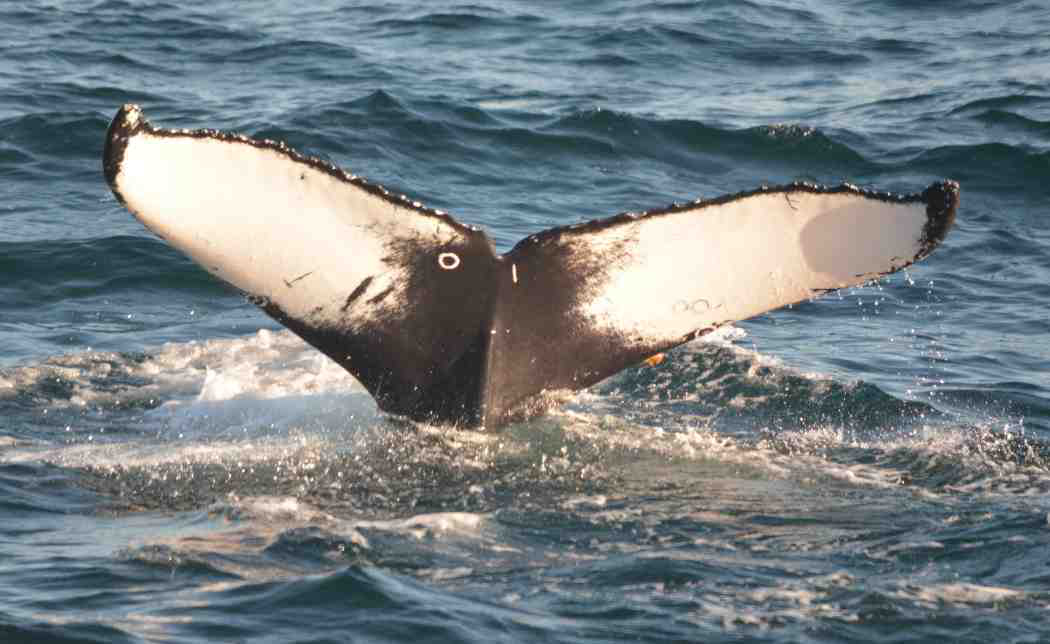

In [5]:
Image.open(random.choice(train_imgs))

In [6]:
train['Image_2'] = train["Image"].map(lambda x : "train/"+x)

In [7]:
train.head()

,Image,Id,Image_2
0,00022e1a.jpg,w_e15442c,train/00022e1a.jpg
1,000466c4.jpg,w_1287fbc,train/000466c4.jpg
2,00087b01.jpg,w_da2efe0,train/00087b01.jpg
3,001296d5.jpg,w_19e5482,train/001296d5.jpg
4,0014cfdf.jpg,w_f22f3e3,train/0014cfdf.jpg


In [8]:
ImageToLabelDict = dict( zip(train["Image_2"],train["Id"]))

In [9]:
Size = 64
# Image resizing and black and white conversion
def Image_augmentation(filename):
    img = Image.open(filename).convert("LA").resize((Size,Size))
    return np.array(img)[:,:,0]

train_img = np.array([Image_augmentation(img) for img in train_imgs])
# test_img = np.array([Image_augmentation(img) for img in test_imgs])

In [10]:
print("training image {}".format(train_img.shape[0]))
# print("training image {}".format(y.shape[0]))

training image 9850


In [11]:
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.le.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

In [12]:
# from mapping dict to images we get the labels i.e. of the images
y= list (map(ImageToLabelDict.get,train_imgs))

In [13]:
lohe = LabelOneHotEncoder()
y_cat= lohe.fit_transform(y)

In [23]:
WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : lohe.le.inverse_tranform( [[x]])
CountDict = dict( train["Id"].value_counts())
class_weight_dic = { lohe.le.transform( [image_name])[0] : WeightFunction(count) for image_name, count in CountDict.items()}
del CountDict

In [19]:
# more preprocessing of image
train_img = train_img.reshape((-1,Size,Size,1))
input_shape = train_img[0].shape
x_train = train_img.astype("float32")
y_train = y_cat

In [28]:
type(x_train)

numpy.ndarray

In [17]:
image_gen = ImageDataGenerator(rescale= 1./255,rotation_range = 10, width_shift_range = .15,
                               height_shift_range = .15, horizontal_flip= True)

image_gen.fit(x_train,augment = True)

In [32]:
batch_size = 256
num_classes = len(y_cat.toarray()[0])
epochs = 20

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(128, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (5, 5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.33))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.33))
model.add(Dense(12, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()
model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
          steps_per_epoch=  x_train.shape[0]//batch_size,
          epochs=epochs,
          verbose=1,
          class_weight=class_weight_dic)

x_train shape: (9850, 64, 64, 1)
9850 train samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 256)       819456    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_5 (Flatten)     

In [30]:
score = model.evaluate(x_train, y_train.toarray(), verbose=0)
print('Training loss: {0:.4f}\nTraining accuracy:{1:.4f}'.format(*score))

Training loss: 8.1877
Training accuracy:0.0822
